<a href="https://colab.research.google.com/gist/g00g1y5p4/095dc24ab0eccff878bd7fc1b3d51783/image_restoration_for_medical_field_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import os,time

In [ ]:
from IPython import display

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 64
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
import pickle
# Read from file.
file = open("/content/drive/MyDrive/project/data.pkl", "rb");
x_train = pickle.load(file)
x_train_noisy = pickle.load(file)
file.close()

In [ ]:
from sklearn.model_selection import train_test_split
 
x_train_, x_test, x_train_noisy_, x_test_noisy = train_test_split(x_train, x_train_noisy,shuffle=128)

In [ ]:
#tf.data.Dataset.batch(x_train_,BATCH_SIZE)

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
 
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
 
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
 
  result.add(tf.keras.layers.LeakyReLU())
 
  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(x_train_[0], 0))
print (down_result.shape)

(1, 64, 64, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
 
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
 
  result.add(tf.keras.layers.BatchNormalization())
 
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))
 
  result.add(tf.keras.layers.ReLU())
 
  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input((128, 128, 3))
  print(1)
 
  down_stack = [
    downsample(128, 4, apply_batchnorm=False),
    #downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
    #downsample(128, 4),  # (bs, 64, 64, 128)
    downsample(256, 4),  # (bs, 32, 32, 256)
    downsample(512, 4),  # (bs, 16, 16, 512)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]
 
  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4), #apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4), #apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512, 4),  # (bs, 16, 16, 1024)
    upsample(256, 4),  # (bs, 32, 32, 512)
    upsample(128, 4),  # (bs, 64, 64, 256)
    #upsample(64, 4),  # (bs, 128, 128, 128)
    #upsample(64, 4)
  ]
 
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)
 
  x = inputs
 
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
 
  skips = reversed(skips[:-1])
 
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  x = last(x)
 
  return tf.keras.Model(inputs=inputs, outputs=x)

1


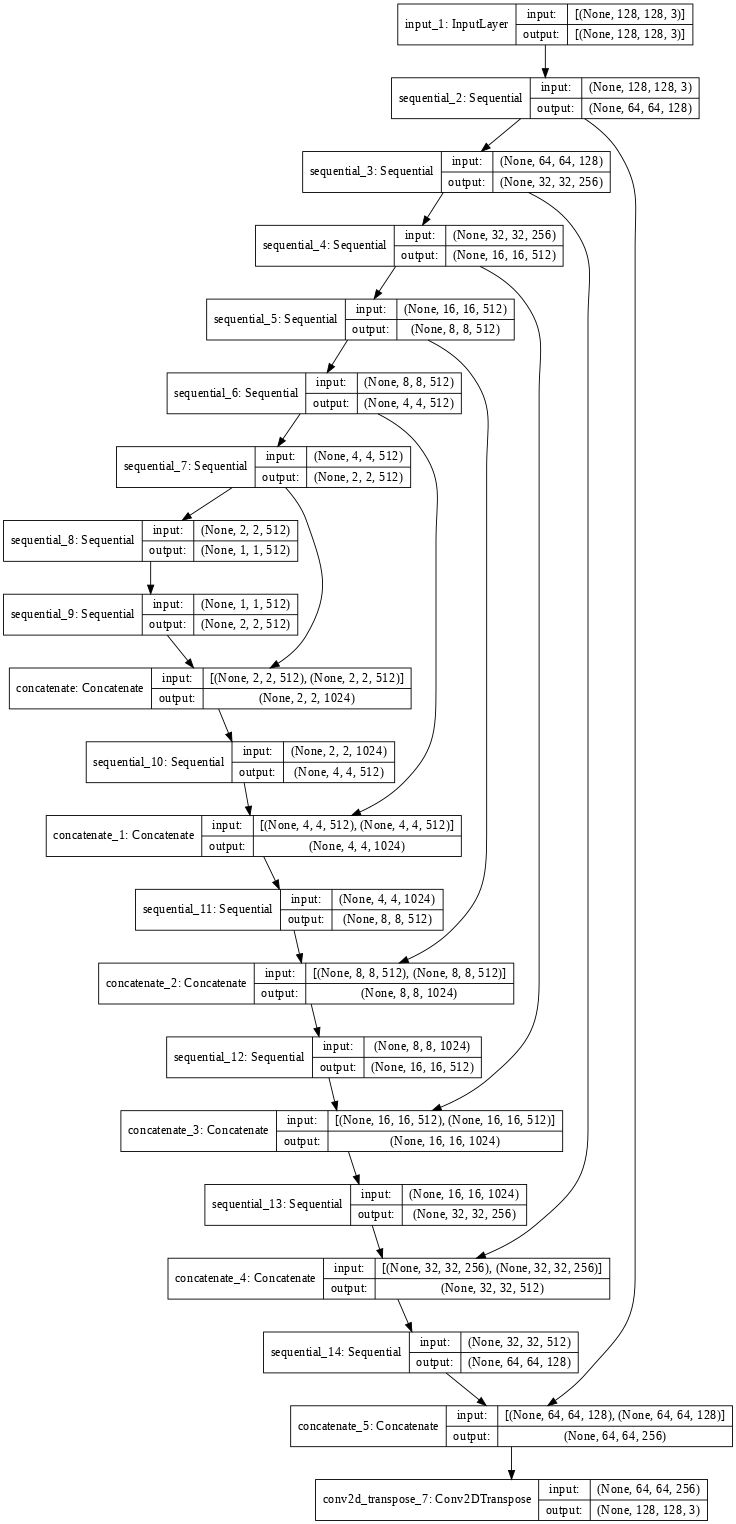

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
BATCH_SIZE=64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


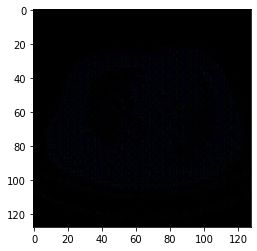

In [ ]:
gen_output = generator(x_train_noisy_[0][tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
 
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
 
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
 
  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
 
  inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')
 
  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)
  down1 = downsample(64, 4, False)(x)
  #down1 = downsample(64, 4, False)(down1)  # (bs, 128, 128, 64)
  #down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down1)  # (bs, 32, 32, 256)
 
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)
 
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
 
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
 
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
 
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)
 
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

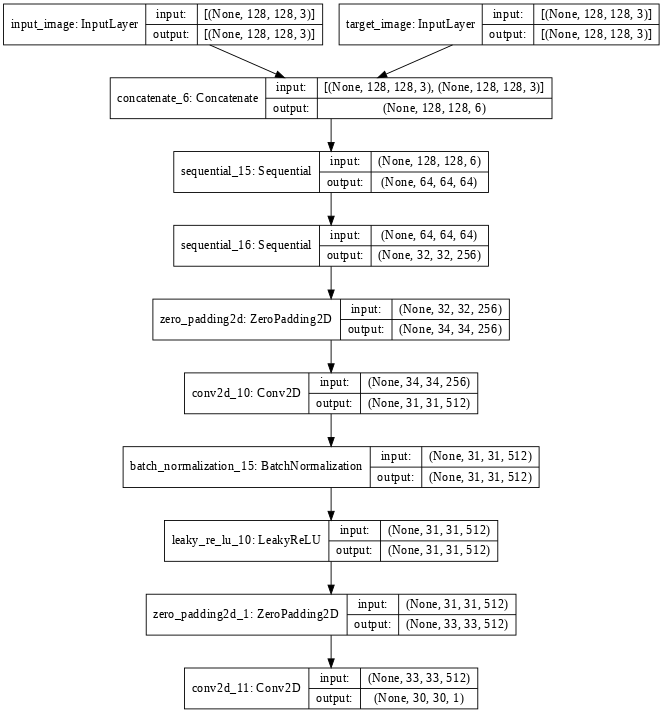

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

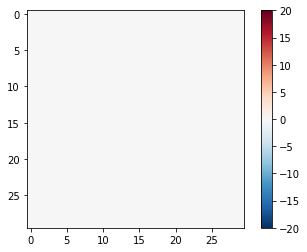

In [ ]:
disc_out = discriminator([x_train_noisy_[0][tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
 
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
 
  total_disc_loss = real_loss + generated_loss
 
  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/project/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
'''ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_prefix, max_to_keep=2)
# if a checkpoint exists, restore the latest checkpoint.
print(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
  checkpoint.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')'''


"ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_prefix, max_to_keep=2)\n# if a checkpoint exists, restore the latest checkpoint.\nprint(ckpt_manager.latest_checkpoint)\nif ckpt_manager.latest_checkpoint:\n  checkpoint.restore(ckpt_manager.latest_checkpoint)\n  print ('Latest checkpoint restored!!')"

In [ ]:
def generate_images(model, test_input, tar):
  print(111)
  prediction = model(test_input, training=True)
  print(111)
  plt.figure(figsize=(15, 15))
 
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
 
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

111
111


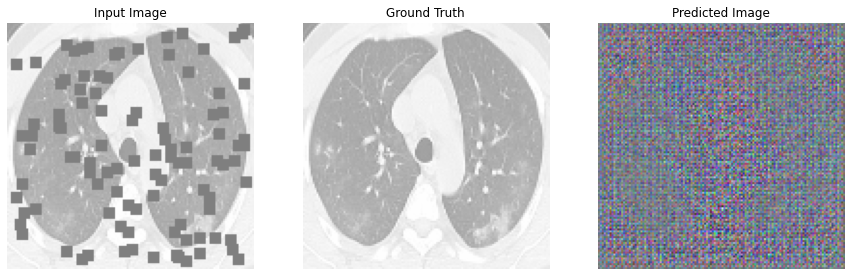

In [ ]:
example_input=x_train_noisy_[100:101]
example_target=x_train_[100:101]
generate_images(generator, example_input, example_target)

In [ ]:
EPOCHS = 150

In [ ]:
import datetime
log_dir="/content/drive/MyDrive/project/logs/"
 
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
 
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
 
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
 
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
 
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
 
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
len(x_train)

9287

In [ ]:
display.clear_output

<function IPython.core.display.clear_output>

In [ ]:
import os

In [ ]:
lenl=len(x_test)
def fitt(x_train_,x_train_noisy_, epochs, x_test,x_test_noisy):
  k=0
  for epoch in range(epochs):
    start = time.time()
 
    display.clear_output(wait=True)
 
    #lenl=len(x_test)
 
    example_input=x_test_noisy[k:k+1]
    example_target=x_test[k:k+1]
    generate_images(generator, example_input, example_target)
    if k==lenl-2:
      k=0
    k+=1
    print("Epoch: ", epoch)
 
    # Train
    n=0
    s=0
    for i in range(len(x_train_)):
      if (n+1) % 100 == 0:
        print('.', end='')
        s+=1
        n=0
      if s==100:
        print()
        s=0
      input_image=x_train_noisy_[i:i+1]
      target=x_train_[i:i+1]
      train_step(input_image, target, 1)
      n+=1
 
    '''for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)'''
    print()
 
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 3 == 0:
      !rm -Rf /content/drive/MyDrive/project/training_checkpoints/ckpt-*
      checkpoint.save(file_prefix=checkpoint_prefix)
 
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

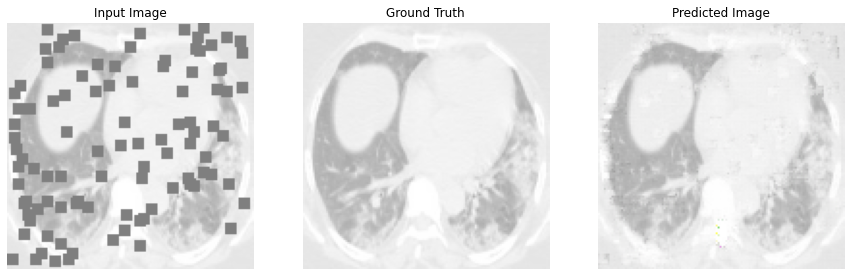

Epoch:  16
..............................

In [ ]:
#fitt(x_train_, x_train_noisy_, EPOCHS, x_test,x_test_noisy)

In [ ]:
!ls {checkpoint_dir}

checkpoint		     ckpt-16.index		  ckpt-19.index
ckpt-16.data-00000-of-00001  ckpt-19.data-00000-of-00001


In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
len(x_test)

2322

In [ ]:
# Run the trained model on a few examples from the test dataset
for k in range(2280,2300):
  example_input=x_test_noisy[k:k+1]
  example_target=x_test[k:k+1]
  generate_images(generator, example_input, example_target)

111
111


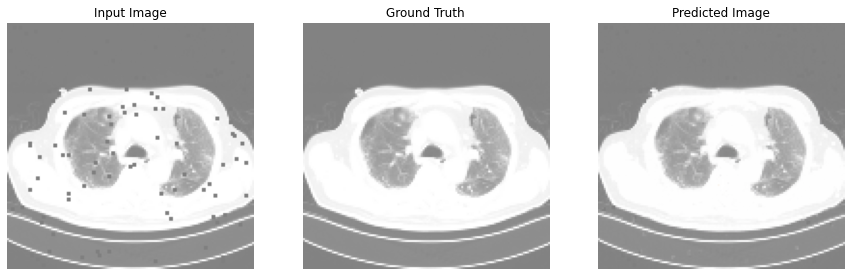

Epoch:  25
...................................

In [ ]:
fitt(x_train_, x_train_noisy_, 150, x_test,x_test_noisy)